In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

stationary=True
class Bandit():
  def __init__(self, arm_count):
    """
    Les algos essaient d'apprendre quel bras de bandit est le meilleur pour maximiser la récompense.
   Il le fait en modélisant la distribution des armes de bandit avec un Bêta, 
  en supposant que la vraie probabilité de succès d'une arme est distribuée par Bernouilli.
    """
    self.arm_count = arm_count
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.arm_count)
  
  def get_reward_regret(self, arm): # Renvoie une récompense aléatoire pour l'action du bras.
    """ on Suppose que les actions sont indexées à 0 //// l'argument  arm  est un entier
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # stimuler l'échantillonnage bernoulli
    sim = np.random.uniform(0,1,self.arm_count)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    regret = self.thetas.max() - self.thetas[arm]
    return reward, regret

In [2]:
class BetaAlgo():
  """ Les algos essaient d'apprendre quel bras de bandit est le meilleur pour maximiser la récompense.
   Il le fait en modélisant la distribution des armes de bandit avec un Bêta, 
  en supposant que la vraie probabilité de succès d'une arme est distribuée par Bernouilli. """
  def __init__(self, bandit): # l'argument bandit : la classe de bandit que l'algo essaie de modéliser
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward

class BernGreedy(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)
  
  @staticmethod
  def name():
    return 'beta-greedy'
   
  def get_action(self): # Les paramètres de Bernouilli sont les valeurs attendues du bêta
    theta = self.alpha / (self.alpha + self.beta)
    return theta.argmax()
  
class BernThompson(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self): # Les paramètres de Bernouilli sont échantillonnés à partir du bêta
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()

In [3]:
epsilon = 0.1
class EpsilonGreedy():
  
  def __init__(self, bandit):
    global epsilon
    self.epsilon = epsilon
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # vecteur Q : valeurs des actions
    self.N = np.zeros(self.arm_count) # vecteur N : vecteur du nombre de fois que chaque bras a été tiré
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # incrémentation du nombre de fois que arm a été tiré
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # mise à jour du valeur d'action Q de arm
 
  

In [4]:
ucb_c = 2
class UCB():
    
  def __init__(self, bandit):
    global ucb_c
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # valeurs des actions
    self.N = np.zeros(self.arm_count) + 0.0001 # vecteur du nombre de fois que chaque bras a été tiré
    self.timestep = 1
  @staticmethod
  def name(): return 'ucb'
  def get_action(self):
    ln_timestep = np.log(np.full(self.arm_count, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1  # incrémentation (mise à jour) du nombre de fois que (arm) a été tiré
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # mise à jour du valeur d'action Q de arm

In [5]:
def plot_data(y): # y est un vecteur 1D  
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
def multi_plot_data(data, names): # data,names sont des listes de vecteurs
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()
def simulate(simulations, timesteps, arm_count, Algorithm): # Simule l'algorithme sur des époques de 'simulations'
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets
def experiment(arm_count, timesteps=1000, simulations=1000):  #  Configuration standard pour toutes les expériences
 """  Arguments :   timesteps : (int) nombre de pas pour que l'algo apprenne le bandit
                     simulations : (int) nombre d'époques  """
 algos = [EpsilonGreedy, UCB, BernThompson]
 regrets = []
 names = []
 for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
 multi_plot_data(regrets, names)

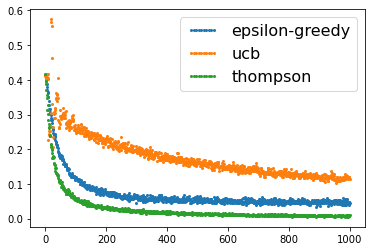

In [6]:
# Expérience 1
arm_count = 10 # nombre de bras/actions
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

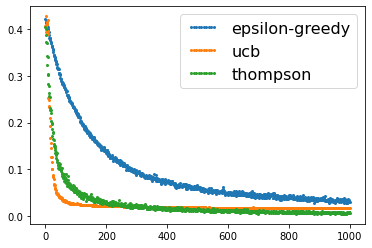

In [7]:
# Expérience 2
arm_count = 10 # number of arms in bandit
epsilon = 0.03
ucb_c = 0.1
stationary=True
experiment(arm_count)

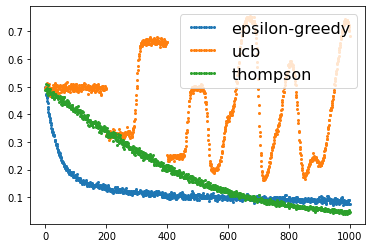

In [8]:
# Expérience 3
arm_count = 200 ; epsilon = 0.1 ; ucb_c = 2
stationary=True
experiment(arm_count)

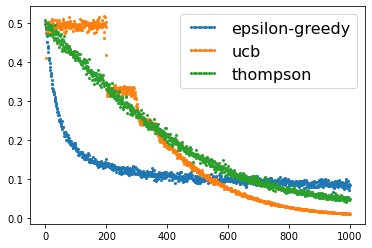

In [9]:
# Expérience 4
arm_count = 200 ; epsilon = 0.1 ; ucb_c = 0.01
stationary=True
experiment(arm_count)

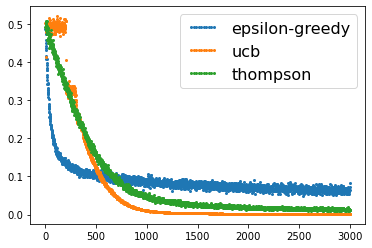

In [10]:
# Expérience 5
arm_count = 200 ; epsilon = 0.1 ; ucb_c = 0.01
stationary=True
experiment(arm_count, timesteps=3000, simulations=1000)